In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import requests as re

sns.set_context('poster')
sns.set_style('whitegrid')


from sklearn.tree import export_graphviz


#Trees
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Preprocessing packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer #One hot encoding
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Metrics
from sklearn.metrics import confusion_matrix, auc, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus 
from IPython.display import Image 

#Bootstrap
from sklearn.utils import resample

%matplotlib inline


In [3]:
df = pd.read_json('train_data.json')
test = pd.read_json('test_data.json')

In [147]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12576 entries, 28870 to 19205
Data columns (total 43 columns):
Balcony                 12576 non-null int64
Cats Allowed            12576 non-null int64
Common Outdoor Space    12576 non-null int64
Dining Room             12576 non-null int64
Dishwasher              12576 non-null int64
Dogs Allowed            12576 non-null int64
Doorman                 12576 non-null int64
Elevator                12576 non-null int64
Exclusive               12576 non-null int64
Fitness Center          12576 non-null int64
Garden/Patio            12576 non-null int64
Hardwood Floors         12576 non-null int64
High Speed Internet     12576 non-null int64
Laundry In Building     12576 non-null int64
Laundry in Building     12576 non-null int64
Laundry in Unit         12576 non-null int64
Loft                    12576 non-null int64
New Construction        12576 non-null int64
No Fee                  12576 non-null int64
Outdoor Space           12576 no

In [18]:
def interestValues(x):
    if 'low' in x:
        return 0
    elif 'med' in x:
        return .5
    else:
        return 1

In [ ]:
df['interestVal'] = df['interest_level'].apply(interestValues)

In [ ]:
df.interest_level.value_counts()

In [ ]:
df.interestVal.value_counts()

In [ ]:
cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(df, x_vars=['interestVal'], y_vars=cols)
plt.savefig('interestLevelPairwise.png')

In [ ]:
# Correlation Matrix of Data
sns.heatmap(df.corr())

In [ ]:
# Side by Side Box Plot of log(Price) vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['price'].apply(np.log))

In [ ]:
# Side by Side Box Plot of Bathrooms vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['bathrooms'])

In [ ]:
df['bedrooms'] = df['bedrooms'].apply(float)
df['bedrooms'].fillna(0, inplace=True)
df['bathrooms'].fillna(0, inplace=True)

In [ ]:
df['studio'] = df['description'].apply(lambda x : 'studio' in x.lower())

In [ ]:
sns.lmplot(col='interest_level',x='bedrooms', y='bathrooms', data=df, ci=None, hue='studio')

In [ ]:
# Side by Side Box Plot of Bedrooms vs. High, Medium, and Low Interest
sns.boxplot(x=df['interest_level'], y=df['bedrooms'])

In [ ]:
# See if geographical location affects interest level
sns.lmplot(x="latitude", y="longitude", hue="interest_level", data=df, fit_reg=False, legend=True, markers='.')

If we drop these two locational outliers and zoom in on the clustered points, maybe we can find something out about location... @Braden @Brianna what is the best way to remove these points?

Those points are plotted at the (lat, long) of (0, -120). This is the standard return of googlemap's api if it cannot find the address due to formatting. Therefore, we should drop them.

In [ ]:
outRem = df[df['latitude'] > 5]
outRem = outRem[outRem['longitude'] > -110]

In [ ]:
sns.lmplot(x='latitude', y='longitude', hue='interest_level', data = outRem, size=10, ci=False)
plt.xlim([40, 41.5])
plt.ylim([-75.0,-72.5])

In [ ]:
sns.lmplot(x='latitude', y='longitude', col='interest_level', data = outRem)

In [ ]:
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='high'])

In [ ]:
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='medium'])

In [ ]:
sns.lmplot(x='latitude', y='longitude', data = outRem[outRem['interest_level']=='low'])

In [ ]:
# perform variable selection according to recitation!

### Trees: Part 1

First we explore classification trees by fitting a classification tree with all compatible predictors and displaying the results of the tree using GraphViz. Below the tree was run with a max depth of 5 in order to make visualization possible.

In [10]:
train = pd.read_json('train_data.json')
train['interest_level_conv'] = train['interest_level'].apply(interestValues)

train, test = train_test_split(train,test_size = .3,random_state = 42)

altered_train = train.drop(['interest_level','interest_level_conv','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'], axis=1)
altered_test = test.drop(['interest_level','interest_level_conv','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'], axis=1)


y_train = train['interest_level']
y_test = test['interest_level']
print("Value Counts: \n {} \n \n".format(test.interest_level.value_counts()))
tree_fit = tree.DecisionTreeClassifier(max_depth=9)
tree_fit.fit(altered_train,y_train)      
print("The test accuracy is: {} \n".format(tree_fit.score(altered_test,y_test)))
confusion = confusion_matrix(tree_fit.predict(altered_test),y_test,labels=['low','medium','high'])
print("Confusion Matrix: \n \n Low Medium High \n{}".format(confusion))
print('\n Low Classification Accuracy: {} \n Medium Classification Accuracy: {} \n High Classification Accuracy: {}'.format(8606/8780,163/2794,94/1002))


Value Counts: 
 low       8780
medium    2794
high      1002
Name: interest_level, dtype: int64 
 

The test accuracy is: 0.7039599236641222 

Confusion Matrix: 
 
 Low Medium High 
[[7965 1948  475]
 [ 722  726  365]
 [  93  120  162]]

 Low Classification Accuracy: 0.9801822323462415 
 Medium Classification Accuracy: 0.05833929849677881 
 High Classification Accuracy: 0.09381237524950099


In [140]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(3) / len(y_test)

low       0.698155
medium    0.222169
high      0.079676
Name: interest_level, dtype: float64

In [141]:
labels = list(altered_train.columns.values)

The tree below is an example visualization of what the optimal classification tree looks like at depth 4. At higher depths, the image did not load. It is clear from here that xxxxx TODO: ANALYSIS

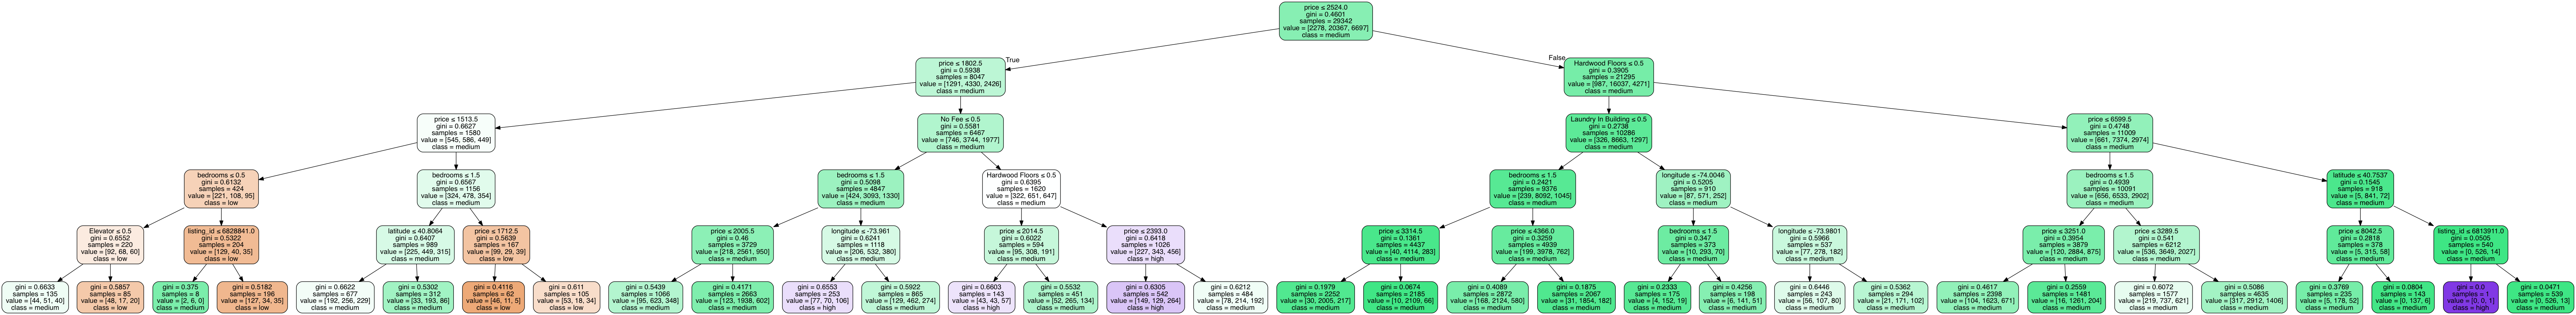

In [146]:
#create a labels = [] Tag
dot_data = tree.export_graphviz(tree_fit, out_file=None, feature_names=labels, class_names = ['low','medium','high'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

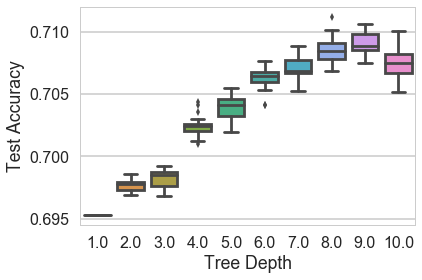

In [136]:
#We perform a 100 try 10fold cross validation
score = np.array([])# Array to store Misclassification Error
depth = np.array([]) # Array to store tree depth

train = pd.read_json('train_data.json')
altered_train_ = train.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'],axis=1)
y_train = train['interest_level']

clf = tree.DecisionTreeClassifier() #Define model ot be used
for trial in range(30):
    cv_method = KFold(n_splits=10,shuffle=True) #Define CV method
    for tree_depth in range(1,11,1):
        clf.set_params(max_depth = tree_depth)
        depth = np.append(depth,tree_depth)
        error = np.mean(cross_val_score(clf,altered_train_,y_train,cv = cv_method,scoring = 'accuracy')) #Run cross validation
        score = np.append(score,error)
        
sns.boxplot(x = depth,y = score)
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')

We can conclude from this K-Fold Cross Validation that the depth of tree that yields the best test accuracy is 9.

Next, using a depth of 9, we perform the bagging technique in order to reduce variance in the model. Bagging below is performed with 300 different trees, and each tree is randomly sampled with replacement 4000 data points (about 1/3 of all the data points).

### Trees: Part 2- Bagging

In [12]:
#Bagging of trees of depth 9
# Choosing number of trees tested with to 1000, 3000 random samples taken to fit each tree. 
train = pd.read_json('train_data.json')
N = 300
preds = [[] for _ in range(N)]
for sample in range(N):
    altered_train_boot = train.sample(4000,replace=True,random_state=sample)
    train_bootstrap = altered_train_boot.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'],axis=1)
    y_train = altered_train_boot['interest_level']
    tree_fit = tree.DecisionTreeClassifier(max_depth=9)
    tree_fit.fit(train_bootstrap,y_train)      
    preds[sample] = tree_fit.predict(altered_test).tolist()


In [13]:
def most_common(lst):
    return max(set(lst), key=lst.count)
rearrange = [[x[y] for x in preds] for y in range(0,12576)]
final_pred = [most_common(x) for x in rearrange]
scoring = [(x,y) for x,y in zip(final_pred,y_test.tolist()) if x==y]
score = len(scoring)/len(final_pred)
print("The bagged tree results in a classification accuracy of {}".format(score))

The bagged tree results in a classification accuracy of 0.7278148854961832


### Trees: Part 3- Random Forests
The next thing we explored were random forests with all the applicable predictors. In using a random forest, there are a couple hyperparameters we need to specify in order to get the most accurate model. One of them is the number of trees to use. Using  Below is first an analysis of how many trees we might use to create the model. Following this is 

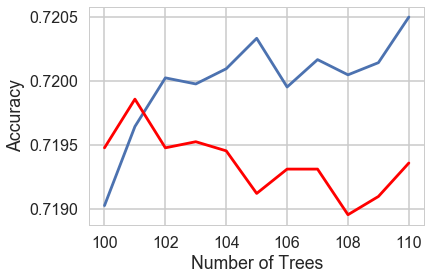

In [9]:
#First lets explore the number of trees
error_rate_sqrt = np.array([])
num_trees_sqrt = np.array([])

error_rate_bag = np.array([])
num_trees_bag = np.array([])

min_trees = 100
max_trees = 110

train = pd.read_json('train_data.json')
altered_train_ = train.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'],axis=1)
y_train = train['interest_level']

sqrt_forest = RandomForestClassifier(warm_start=False, 
                             oob_score=True,
                             max_features="sqrt",
                             random_state = 1)

bagged_tree = RandomForestClassifier(warm_start=False, 
                             oob_score=True,
                             max_features=None,
                             random_state = 1)

for i in range(min_trees,max_trees+1):
    sqrt_forest.set_params(n_estimators=i)
    sqrt_forest.fit(altered_train_, y_train)
    error_rate_sqrt = np.append(error_rate_sqrt,sqrt_forest.oob_score_)
    num_trees_sqrt = np.append(num_trees_sqrt,i)
    
    bagged_tree.set_params(n_estimators=i)
    bagged_tree.fit(altered_train_, y_train)
    error_rate_bag = np.append(error_rate_bag,bagged_tree.oob_score_)
    num_trees_bag = np.append(num_trees_bag,i)

plt.plot(num_trees_sqrt,error_rate_sqrt);
plt.plot(num_trees_bag,error_rate_bag,c='red');
plt.xlabel('Number of Trees');
plt.ylabel('Accuracy');

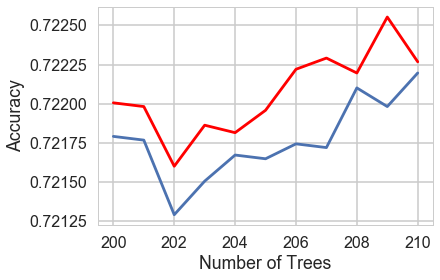

In [5]:
#First lets explore the number of trees
error_rate_sqrt = np.array([])
num_trees_sqrt = np.array([])

error_rate_bag = np.array([])
num_trees_bag = np.array([])

min_trees = 200
max_trees = 210

train = pd.read_json('train_data.json')
altered_train_ = train.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'],axis=1)
y_train = train['interest_level']

sqrt_forest = RandomForestClassifier(warm_start=False, 
                             oob_score=True,
                             max_features="sqrt",
                             random_state = 1)

bagged_tree = RandomForestClassifier(warm_start=False, 
                             oob_score=True,
                             max_features=None,
                             random_state = 1)

for i in range(min_trees,max_trees+1):
    sqrt_forest.set_params(n_estimators=i)
    sqrt_forest.fit(altered_train_, y_train)
    error_rate_sqrt = np.append(error_rate_sqrt,sqrt_forest.oob_score_)
    num_trees_sqrt = np.append(num_trees_sqrt,i)
    
    bagged_tree.set_params(n_estimators=i)
    bagged_tree.fit(altered_train_, y_train)
    error_rate_bag = np.append(error_rate_bag,bagged_tree.oob_score_)
    num_trees_bag = np.append(num_trees_bag,i)

plt.plot(num_trees_sqrt,error_rate_sqrt);
plt.plot(num_trees_bag,error_rate_bag,c='red');
plt.xlabel('Number of Trees');
plt.ylabel('Accuracy');

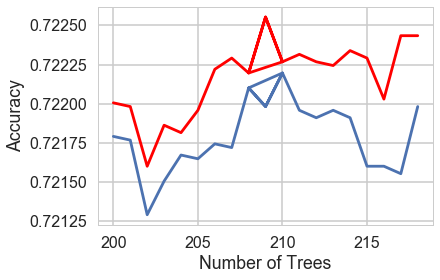

In [6]:
min_trees = 208
max_trees = 218

for i in range(min_trees,max_trees+1):
    sqrt_forest.set_params(n_estimators=i)
    sqrt_forest.fit(altered_train_, y_train)
    error_rate_sqrt = np.append(error_rate_sqrt,sqrt_forest.oob_score_)
    num_trees_sqrt = np.append(num_trees_sqrt,i)
    
    bagged_tree.set_params(n_estimators=i)
    bagged_tree.fit(altered_train_, y_train)
    error_rate_bag = np.append(error_rate_bag,bagged_tree.oob_score_)
    num_trees_bag = np.append(num_trees_bag,i)

plt.plot(num_trees_sqrt,error_rate_sqrt);
plt.plot(num_trees_bag,error_rate_bag,c='red');
plt.xlabel('Number of Trees');
plt.ylabel('Accuracy');

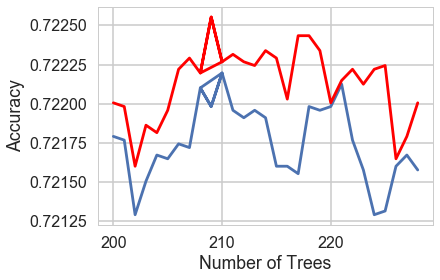

In [7]:
min_trees = 218
max_trees = 228

for i in range(min_trees,max_trees+1):
    sqrt_forest.set_params(n_estimators=i)
    sqrt_forest.fit(altered_train_, y_train)
    error_rate_sqrt = np.append(error_rate_sqrt,sqrt_forest.oob_score_)
    num_trees_sqrt = np.append(num_trees_sqrt,i)
    
    bagged_tree.set_params(n_estimators=i)
    bagged_tree.fit(altered_train_, y_train)
    error_rate_bag = np.append(error_rate_bag,bagged_tree.oob_score_)
    num_trees_bag = np.append(num_trees_bag,i)

plt.plot(num_trees_sqrt,error_rate_sqrt);
plt.plot(num_trees_bag,error_rate_bag,c='red');
plt.xlabel('Number of Trees');
plt.ylabel('Accuracy');

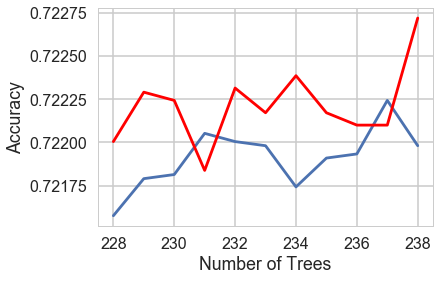

In [8]:
min_trees = 228
max_trees = 238

train = pd.read_json('train_data.json')
altered_train_ = train.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'],axis=1)
y_train = train['interest_level']

error_rate_sqrt = np.array([])
num_trees_sqrt = np.array([])

error_rate_bag = np.array([])
num_trees_bag = np.array([])

sqrt_forest = RandomForestClassifier(warm_start=False, 
                             oob_score=True,
                             max_features="sqrt",
                             random_state = 1)

bagged_tree = RandomForestClassifier(warm_start=False, 
                             oob_score=True,
                             max_features=None,
                             random_state = 1)

for i in range(min_trees,max_trees+1):
    sqrt_forest.set_params(n_estimators=i)
    sqrt_forest.fit(altered_train_, y_train)
    error_rate_sqrt = np.append(error_rate_sqrt,sqrt_forest.oob_score_)
    num_trees_sqrt = np.append(num_trees_sqrt,i)
    
    bagged_tree.set_params(n_estimators=i)
    bagged_tree.fit(altered_train_, y_train)
    error_rate_bag = np.append(error_rate_bag,bagged_tree.oob_score_)
    num_trees_bag = np.append(num_trees_bag,i)

plt.plot(num_trees_sqrt,error_rate_sqrt);
plt.plot(num_trees_bag,error_rate_bag,c='red');
plt.xlabel('Number of Trees');
plt.ylabel('Accuracy');

Now that we have determined that the optimal number of trees is about 210, the next hyperparameter to choose is how many features to choose for each tree sample. Above we studied both the bagged tree and random forests where m < p; m = sqrt(p). Below we run through different numbers of features using the random forest classifier.

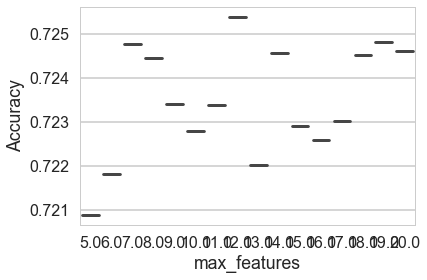

In [4]:
error_rate = np.array([])
num_features = np.array([])

train = pd.read_json('train_data.json')
altered_train_ = train.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'],axis=1)
y_train = train['interest_level']

min_features = 5
max_features = 20

clf = RandomForestClassifier(oob_score=True,n_estimators=210)
for m in range(min_features,max_features+1):
    clf.set_params(max_features=m)
    clf.fit(altered_train_, y_train)
    error_rate = np.append(error_rate,clf.oob_score_)
    num_features = np.append(num_features,m)

sns.boxplot(x = num_features,y = error_rate)
plt.xlabel('max_features');
plt.ylabel('Accuracy');

After determining the optimal hyperparameters given the constraint of limited computational power, we have determined that for all the feasible predictors in the dataset, the most optimal tree is a Random Forest with TODO x trees and y maximum features. 

In [57]:
train = pd.read_json('train_data.json')

train, test = train_test_split(train,test_size = .3,random_state = 42)

altered_train = train.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'], axis=1)
altered_test = test.drop(['interest_level','description','display_address','created','building_id','features', 'manager_id', 'photos', 'street_address'], axis=1)


y_train = train['interest_level']
y_test = test['interest_level']

classifier = RandomForestClassifier(oob_score=True, n_estimators=200,
                                    random_state=1, max_features='sqrt')
classifier.fit(altered_train, y_train)
error = classifier.oob_score_

In [60]:
print("The resulting out of bag score is : {}".format(error))

The resulting out of bag score is : 0.7128007634108104


In [61]:
probs = classifier.predict_proba(altered_test)
print(probs)

[[ 0.01   0.845  0.145]
 [ 0.775  0.13   0.095]
 [ 0.105  0.59   0.305]
 ..., 
 [ 0.01   0.96   0.03 ]
 [ 0.125  0.62   0.255]
 [ 0.01   0.53   0.46 ]]


In [62]:
y_test_num = y_test.apply(interestValues)

In [63]:
print(classifier.classes_)
print(y_test_num.head())
df = pd.DataFrame(index=None)
df['interest_real'] = y_test_num
df['interest_predicted'] = classifier.predict(altered_test)
df['prob_high'] = probs[:,0]
df['prob_low'] = probs[:,1]
df['prob_med'] = probs[:,2]
print(df.head(50))
print(df.interest_predicted.value_counts())
predicted = classifier.predict(altered_test)
predicted = pd.Series(predicted)
predicted = predicted.apply(interestValues)

['high' 'low' 'medium']
28870    0.0
24708    0.5
11643    0.5
7231     0.5
305      1.0
Name: interest_level, dtype: float64
       interest_real interest_predicted  prob_high  prob_low  prob_med
28870            0.0                low      0.010     0.845     0.145
24708            0.5               high      0.775     0.130     0.095
11643            0.5                low      0.105     0.590     0.305
7231             0.5                low      0.130     0.735     0.135
305              1.0             medium      0.065     0.430     0.505
35744            0.0                low      0.005     0.970     0.025
9287             0.5                low      0.050     0.600     0.350
7669             0.0                low      0.075     0.735     0.190
11707            0.5                low      0.080     0.595     0.325
32197            0.0                low      0.010     0.585     0.405
19809            0.5                low      0.005     0.790     0.205
39957            0.5  

0.70817579460053448

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_num, predicted, pos_label=1)
auc(fpr, tpr)